Figure 2   

Flash detection and double flash maps for all participants

In [8]:
# Imports
import os
import importlib
import glob
import pandas as pd

# Custom imports
import plotting
importlib.reload(plotting)
from plotting import Plots
plotting = Plots()

import file_extractor
importlib.reload(file_extractor)
from file_extractor import FileExtractor
extractor = FileExtractor()

# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from PIL import Image
from matplotlib.gridspec import GridSpec

sid_list = extractor.get_sids()
plot_dir = extractor.plot_dir

In [9]:
for sid in sid_list:
    # if polar/indiv does not exist, create it
    if not os.path.exists(f'{extractor.plot_dir}/polar/indiv'):
        os.makedirs(f'{extractor.plot_dir}/polar/indiv')
    # skip if file already exists
    if os.path.exists(f'{extractor.plot_dir}/polar/indiv/{sid}_polar.png'):
        continue
    plotting.polar_individual(sid)
    print(f'Finished plotting ploar plots for {sid}')

# Group plots
if not glob.glob(f"{extractor.plot_dir}/polar/*_polar.png"):
    plotting.polar_group()


C:\Users\Ailene\AppData\Local\Temp\ipykernel_29464\2613070312.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 0.9]) #left, bottom, right, top


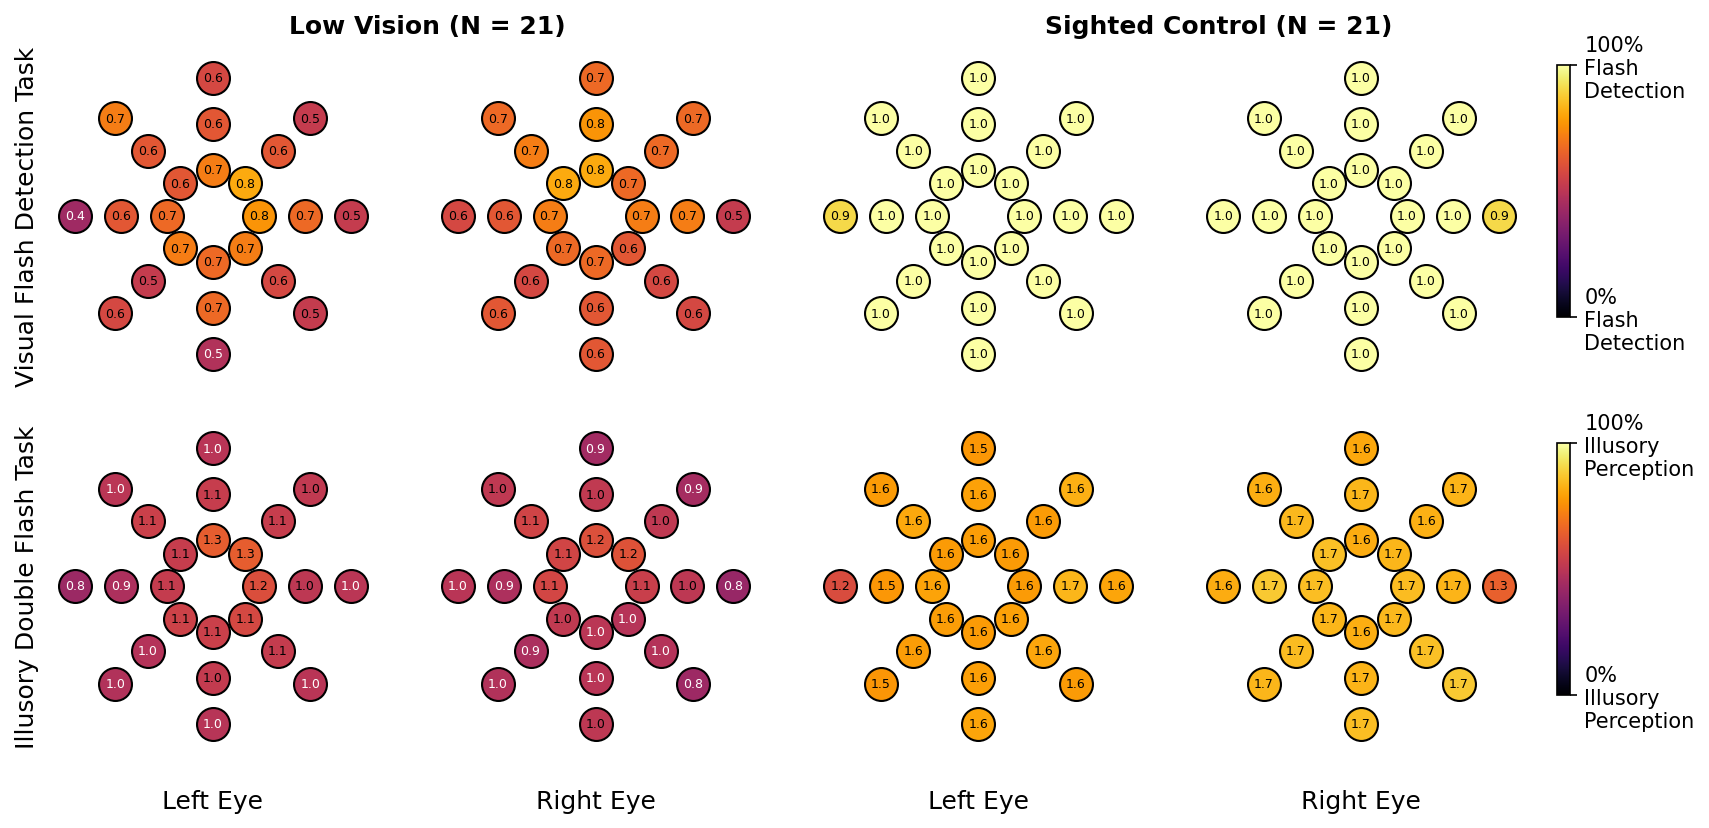

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), dpi=150, subplot_kw={'projection': 'polar'})
# fig.suptitle('Mean Number of Flashes Perceived by Task', fontweight='bold')

axes = ax.flatten()

i=0
for task in ['vf', 'bdf']:
    for group in ['LV', 'SV']:
        for eye in ['L', 'R']:
            plotting.polar_ax(axes[i], task, eye, group, marker_size=250)
            i += 1


ax[0, 0].set_ylabel('Visual Flash Detection Task', fontsize=12)
ax[1, 0].set_ylabel('Illusory Double Flash Task', fontsize=12)

fig.text(0.18, 0.88, f"Low Vision (N = {extractor.get_N('LV')})", fontweight='bold', fontsize=12)
fig.text(0.6, 0.88, f"Sighted Control (N = {extractor.get_N('SV')})", fontweight='bold', fontsize=12)

# Add color bars for top and bottom rows
norm_top = mcolors.Normalize(vmin=0, vmax=1)
norm_bottom = mcolors.Normalize(vmin=0, vmax=2)
cmap = cm.inferno
cbar_top = fig.colorbar(cm.ScalarMappable(norm=norm_top, cmap=cmap), 
                        ax=ax[0, :], orientation='vertical', 
                        fraction=0.02, pad=0.01, shrink=0.8)
cbar_top.set_ticks([0, 1])
cbar_top.set_ticklabels(['0%\nFlash\nDetection', 
                            '100%\nFlash\nDetection'],
                            fontsize=10)

cbar_bottom = fig.colorbar(cm.ScalarMappable(norm=norm_bottom, cmap=cmap), 
                            ax=ax[1, :], orientation='vertical', 
                            fraction=0.02, pad=0.01, shrink=0.8)
cbar_bottom.set_ticks([0, 2])
cbar_bottom.set_ticklabels(['0%\nIllusory\nPerception', 
                            '100%\nIllusory\nPerception'],
                            fontsize=10)

plt.tight_layout(rect=[0, 0, 0.88, 0.9]) #left, bottom, right, top


In [11]:
df = pd.read_csv('csv/all_participants.csv')
f1b0 = df[(df['n_flash']==1) & (df['n_beep']==0)]
f1b2 = df[(df['n_flash']==1) & (df['n_beep']==2)]

mean_f1b0 = (
    f1b0.groupby(['sid', 'group'])['response']
    .mean()
    .reset_index()
    .rename(columns={'response': 'mean_f1b0'})
)

mean_f1b2 = (
    f1b2.groupby(['sid', 'group'])['response']
    .mean()
    .reset_index()
    .rename(columns={'response': 'mean_f1b2'})
)

merged = pd.merge(mean_f1b0, mean_f1b2, on=['sid', 'group'])

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

results = {}
for grp in merged['group'].unique():
    data = merged[merged['group'] == grp]
    stat, p = wilcoxon(data['mean_f1b0'], data['mean_f1b2'])
    results[grp] = {'n': len(data), 'stat': stat, 'p': p}

results_df = pd.DataFrame(results).T
pvals = [results_df.loc[g, 'p'] for g in results_df.index]
reject, p_corr, _, _ = multipletests(pvals, method='bonferroni')

results_df['p_corrected'] = p_corr
results_df['significant'] = reject
print(results_df)


                    n  stat         p  p_corrected  significant
Low Vision       21.0  13.0  0.000084     0.000168         True
Sighted Control  21.0   0.0  0.000059     0.000119         True


In [12]:
mean_f1b2.groupby(['group'])['mean_f1b2'].agg(['mean', 'sem']).round(2)

,mean,sem
group,,
Low Vision,1.03,0.15
Sighted Control,1.61,0.10


In [13]:
mean_f1b0.groupby(['group'])['mean_f1b0'].agg(['mean', 'sem']).round(2)

,mean,sem
group,,
Low Vision,0.55,0.07
Sighted Control,0.98,0.01
